In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


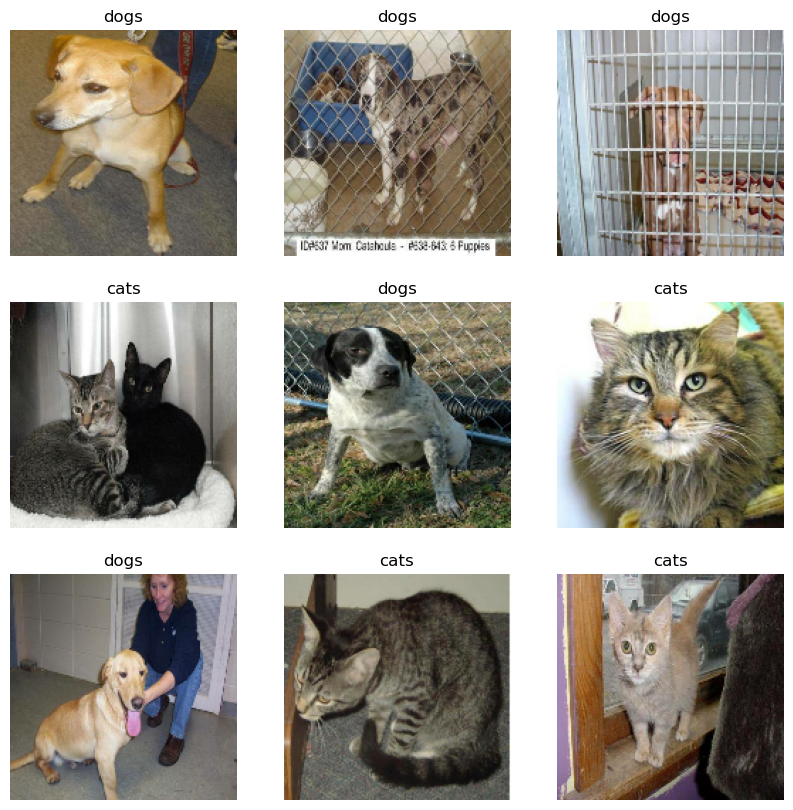

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


## Preprocessing

Configure the dataset for performance

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Use data augmentation

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

MobileNetV2 uses a input range of [-1, 1], while the input now is in [0, 255]

In [8]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Using MobileNetV2

Not including **top**, because this layer is the last one, with the flatten and output layers. We need the **bottleneck layer**, the last later containing only feature maps.

In [9]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [10]:
'Input:', IMG_SHAPE

('Input:', (160, 160, 3))

Check model output

In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 1280])

The output is (5, 5, 1280). 32 is the batch

In [12]:
# freeze base
base_model.trainable = False

### Add the new top layer to classification

The `GlobalAvgPool2D` simply scales down the (5,5,1280) dimensions (like `MaxPool2D`), while the `Dense` with no *activation* outputs the **logits** (raw predictions on which you would apply the softmax/argmax function to get the predicted class), since there are only 2 classes there is no need for more units or layers.es.

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

In [15]:
# testing
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1280)
(32, 1)


## New Model

In [16]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False) # training=False bc base_model contains BatchNormalization
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [21]:
# inspect the 1281 trainable vars
model.trainable_variables

[<tf.Variable 'dense_1/kernel:0' shape=(1280, 1) dtype=float32, numpy=
 array([[-0.03317735],
        [ 0.01791331],
        [-0.03866262],
        ...,
        [-0.04704187],
        [ 0.02589337],
        [ 0.05056728]], dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

## Non-trained results

In [22]:
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 8s 233ms/step - loss: 0.9822 - accuracy: 0.3589


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.98
initial accuracy: 0.36


## Trained results

In [25]:
initial_epochs = 10

history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 26s 372ms/step - loss: 0.8245 - accuracy: 0.4885 - val_loss: 0.6832 - val_accuracy: 0.5866
Epoch 2/10
63/63 [==============================] - 24s 377ms/step - loss: 0.6250 - accuracy: 0.6460 - val_loss: 0.5022 - val_accuracy: 0.6968
Epoch 3/10
63/63 [==============================] - 23s 370ms/step - loss: 0.4922 - accuracy: 0.7505 - val_loss: 0.3821 - val_accuracy: 0.7785
Epoch 4/10
63/63 [==============================] - 22s 356ms/step - loss: 0.4089 - accuracy: 0.7980 - val_loss: 0.3090 - val_accuracy: 0.8317
Epoch 5/10
63/63 [==============================] - 25s 402ms/step - loss: 0.3612 - accuracy: 0.8290 - val_loss: 0.2593 - val_accuracy: 0.8824
Epoch 6/10
63/63 [==============================] - 26s 412ms/step - loss: 0.3173 - accuracy: 0.8510 - val_loss: 0.2196 - val_accuracy: 0.9047
Epoch 7/10
63/63 [==============================] - 24s 375ms/step - loss: 0.2827 - accuracy: 0.8720 - val_loss: 0.1891 - val_accuracy: 0.9245

In [26]:
acc = history.history['accuracy']
loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

From **Tensorflow**:

The validation metrics are clearly better than the training metrics, the main factor is because layers like `tf.keras.layers.BatchNormalization` and `tf.keras.layers.Dropout` affect accuracy during training. They are turned off when calculating validation loss. It is also because **training metrics** report the **average** for an epoch, while **validation metrics** are evaluated **after** the epoch, so validation metrics see a model that has trained slightly **longer**.

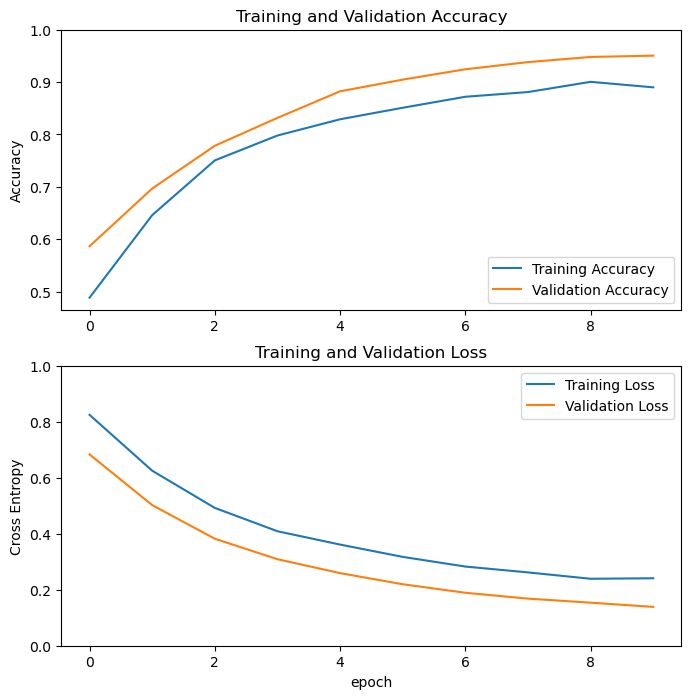

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine-tunning

From **Tensorflow**:

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset. (...) Also, you should try to fine-tune a **small** number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images.

⚠️ **IMPORTANT** ⚠️

This should **only** be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be **too large** (due to the random weights from the classifier) and your pre-trained model will **forget** what it has learned.

In [33]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  154


In [38]:
fine_tune_at = 100

In [39]:
# Freeze all the layers before the fine_tune_at layer
base_model.trainable = True
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

As you are training a much larger model and want to readapt the pretrained weights, it is important to use a **lower learning** rate at this stage. Otherwise, your model could overfit very quickly.

In [41]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10), metrics=['accuracy'])

In [42]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

## Continue training

In [44]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 39s 540ms/step - loss: 0.1491 - accuracy: 0.9380 - val_loss: 0.0531 - val_accuracy: 0.9802
Epoch 11/20
63/63 [==============================] - 37s 584ms/step - loss: 0.1187 - accuracy: 0.9540 - val_loss: 0.0465 - val_accuracy: 0.9827
Epoch 12/20
63/63 [==============================] - 38s 605ms/step - loss: 0.1029 - accuracy: 0.9585 - val_loss: 0.0461 - val_accuracy: 0.9851
Epoch 13/20
63/63 [==============================] - 36s 563ms/step - loss: 0.0974 - accuracy: 0.9625 - val_loss: 0.0421 - val_accuracy: 0.9814
Epoch 14/20
63/63 [==============================] - 34s 534ms/step - loss: 0.0866 - accuracy: 0.9655 - val_loss: 0.0380 - val_accuracy: 0.9864
Epoch 15/20
63/63 [==============================] - 36s 570ms/step - loss: 0.0884 - accuracy: 0.9650 - val_loss: 0.0565 - val_accuracy: 0.9703
Epoch 16/20
63/63 [==============================] - 33s 531ms/step - loss: 0.0882 - accuracy: 0.9645 - val_loss: 0.0397 - val_accuracy:

In [45]:
# increment with the fine tunning results

acc += history_fine.history['accuracy']
loss += history_fine.history['loss']

val_acc += history_fine.history['val_accuracy']
val_loss += history_fine.history['val_loss']

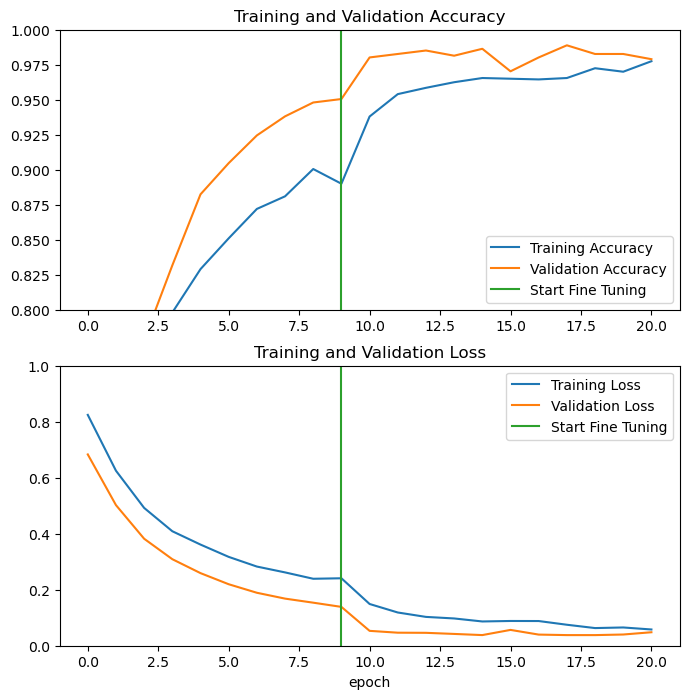

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation

In [47]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 2s 240ms/step - loss: 0.0258 - accuracy: 0.9844
Test accuracy : 0.984375


Let see it running on the images

In [48]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

Predictions:
 [0 1 0 1 0 1 0 0 1 0 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0]
Labels:
 [0 1 0 1 0 1 0 0 1 0 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0]


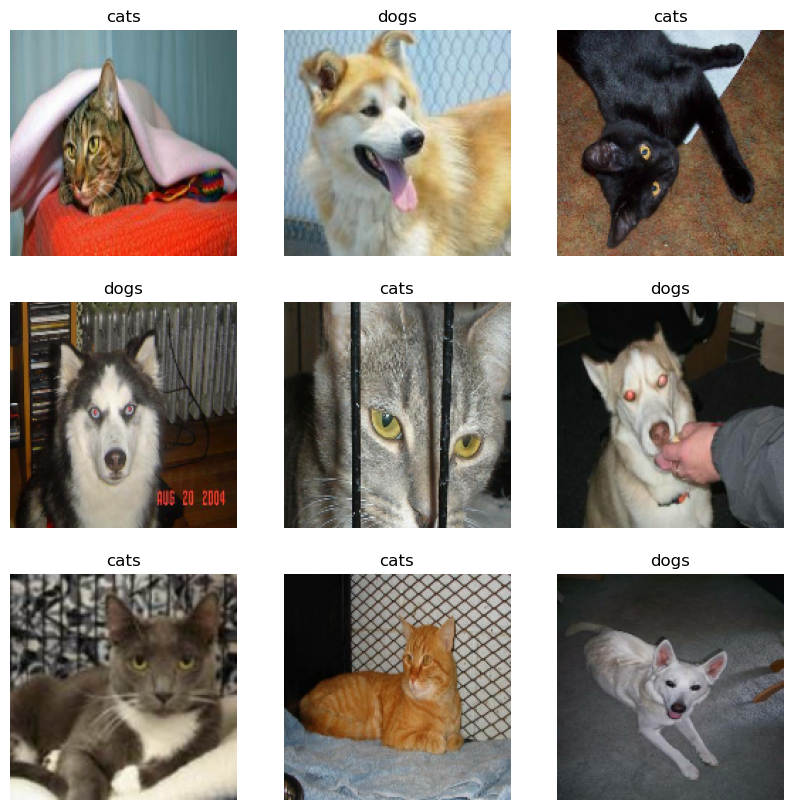

In [49]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")